In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.1 MB/s eta 0:00:00


In [ ]:
import mne

def load_eeglab_set(filepath):
    epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
    return epochs


###EEG Data Preprocessing for EEGNet

This function processes raw EEG data from epochs, preparing it for input into the EEGNet model.

**Steps:**

1. **Extract EEG Data:**  
   The EEG data is extracted from the `epochs` object, resulting in an array with shape `(n_trials, n_channels, n_times)`.

2. **Reshape Data:**  
   To match EEGNet's expected input format, the data is reshaped to have the shape `(n_trials, 1, n_channels, n_times)` (channels-first format).

3. **Event Codes (Labels):**  
   The event labels (or codes) are extracted from the `epochs.events` array. These event codes typically represent different behavioral conditions or task categories.

4. **Label Encoding:**  
   If the labels are not integers (e.g., strings), they are encoded using **LabelEncoder**, converting categorical labels into integer format.

5. **Return Processed Data:**  
   The function returns the reshaped EEG data (`X`), encoded labels (`y`), and the **LabelEncoder** instance for potential reverse label mapping.

> Result: The EEG data is ready for training in EEGNet and the labels are in a format suitable for classification.


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_for_eegnet(epochs):
    X = epochs.get_data()  # Shape: (n_trials, n_channels, n_times)
    y = epochs.events[:, -1]  # Event codes (labels)

    # Reshape to EEGNet format: (n_trials, 1, n_channels, n_times)
    X = X[:, np.newaxis, :, :]

    # Encode labels if they’re not integers
    le = LabelEncoder()
    y = le.fit_transform(y)

    return X.astype(np.float32), y.astype(np.int64), le


Reading and mapping of labels

In [ ]:
import pandas as pd

label_df = pd.read_csv(r"/content/drive/MyDrive/Preprocessed_datasets/trait_anxiety_labels.csv")
label_df["trait_anx_level"] = label_df["trait_anx_level"].map({"low": 0, "high": 1})  # convert to binary
label_df.head(15)


,subject_id,trait_anx_level
0,p2,0
1,p3,1
2,p4,1
3,p5,0
4,p6,0
5,p7,1
6,p8,0
7,p9,0
8,p10,1
9,p11,1


In [ ]:
label_map = dict(zip(label_df["subject_id"], label_df["trait_anx_level"]))


###Loading and Aggregating EEG Data Across Participants

This block loops through multiple preprocessed EEG `.set` files, performs filtering, and builds a dataset for training.

**Key Steps:**

- **Participant Filtering:** Skips participants with noisy/incomplete data (IDs: 1, 13, 23, 52)
- **Data Loading:** Loads EEGLAB `.set` files using a custom `load_eeglab_set` function
- **Label Mapping:** Uses behavioral trait labels (e.g., 'low' or 'high') for each subject
- **Reshaping:** Transforms EEG data to **(samples, 1, channels, time)** for EEGNet
- **Label Replication:** Creates a label per epoch
- **Final Dataset:** Combines data across all valid participants into `X_all` and `y_all`

> Result: `X_all` and `y_all` are ready for preprocessing or model training.


In [ ]:
import os
# Participants to skip
exclude = {1, 13, 23, 52}

all_X, all_y = [], []

for i in range(1, 55):
    if i in exclude:
        continue

    subj_code = f"p{i}"  # matches 'subject_id' in CSV like p2, p3...
    trait_label = label_map[subj_code]  # 'low' or 'high'

    filename = f"p{i}_e1_preprocessed.set"
    filepath = os.path.join(r"/content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data", filename)

    print(f"Processing {filename}")
    epochs = load_eeglab_set(filepath)  # your function

    # Get EEG data as X, dummy y (can use y=0 temporarily)
    X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)

    # EEGNet expects shape (samples, 1, channels, time)
    X = X[:, np.newaxis, :, :]

    # Create y: one label per epoch
    y = [trait_label] * X.shape[0]

    all_X.append(X)
    all_y.extend(y)

# Stack all data
X_all = np.concatenate(all_X, axis=0)
y_all = np.array(all_y)

print("Final shape:", X_all.shape, y_all.shape)

Processing p2_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p2_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p3_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p3_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p4_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p4_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p5_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p5_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p6_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p6_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p7_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p7_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p8_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p8_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
52 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p9_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p9_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p10_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p10_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p11_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p11_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p12_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p12_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p14_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p14_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p15_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p15_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p16_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p16_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p17_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p17_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p18_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p18_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p19_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p19_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p20_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p20_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p21_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p21_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p22_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p22_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p24_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p24_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p25_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p25_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p26_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p26_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p27_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p27_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p28_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p28_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p29_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p29_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p30_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p30_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p31_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p31_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p32_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p32_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p33_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p33_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p34_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p34_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p35_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p35_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p36_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p36_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p37_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p37_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p38_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p38_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p39_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p39_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p40_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p40_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p41_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p41_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p42_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p42_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p43_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p43_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p44_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p44_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p45_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p45_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p46_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p46_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p47_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p47_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p48_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p48_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data
<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p49_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p49_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p50_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p50_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p51_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p51_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p53_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p53_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Processing p54_e1_preprocessed.set
Extracting parameters from /content/drive/MyDrive/Preprocessed_datasets/dataset_preprocessed/env1_preprocessed_data/p54_e1_preprocessed.set...


<ipython-input-3-789131e0a5be>:4: RuntimeWarning: Estimated head radius (4.5 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(filepath, verbose=True)  # directly loads epoched data


Not setting metadata
106 matching events found
No baseline correction applied
0 projection items activated
Ready.
Final shape: (4196, 1, 26, 275) (4196,)


In [ ]:
np.save("X_e1_all.npy", X_all)
np.save("y_e1_all.npy", y_all)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_all)  # 'low' -> 0, 'high' -> 1


In [ ]:
#train/Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import BatchNormalization, Activation, AveragePooling2D, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.callbacks import EarlyStopping


### EEGNet_v2: Compact CNN for EEG Classification

This function defines a lightweight convolutional neural network architecture specifically designed for EEG signal classification.  
The model expects EEG input in **channels-first** format: **(1, Channels, Samples)**.

**Architecture Breakdown:**

1. **Input Layer**  
   - Input shape: (1, Chans, Samples)  
   - EEG signals with one temporal dimension

2. **Block 1 – Temporal Convolution**  
   - Conv2D with kernel size (1 × kernLength)  
   - Captures temporal frequency features

3. **Block 2 – Depthwise Spatial Convolution**  
   - DepthwiseConv2D with (Chans × 1)  
   - Learns spatial filters per channel  
   - Followed by BatchNorm, ELU activation, and pooling

4. **Block 3 – Separable Convolution**  
   - Combines depthwise + pointwise convolution  
   - Efficient fusion of spatial-temporal features  
   - Followed by BatchNorm, ELU, pooling, and dropout

5. **Block 4 – Deeper Separable Convolution**  
   - Further refines learned representations  
   - Same structure: SeparableConv → BN → ELU → Pool → Dropout

6. **Classifier**  
   - Flattened features pass through a Dense layer(With reLu then MLP with Tanh)
   - Final layer: Softmax output for `nb_classes` classification

> Designed for compactness and efficiency — suitable for real-time BCI and EEG-based applications.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization, Activation, AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2

def EEGNet_v2(nb_classes, Chans=26, Samples=275,
              dropoutRate=0.4, kernLength=16, F1=16, D=2, F2=32, norm_rate=0.25):

    input1 = Input(shape=(1, Chans, Samples))  # channels_first format

    # Block 1 - Temporal Convolution
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False,
                    kernel_regularizer=l2(0.001))(input1)
    block1 = BatchNormalization()(block1)

    # Block 2 - Depthwise Convolution (spatial)
    block2 = DepthwiseConv2D((Chans, 1), depth_multiplier=D, use_bias=False,
                             depthwise_regularizer=l2(0.001), padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 2))(block2)
    block2 = Dropout(dropoutRate)(block2)

    # Block 3 - Separable Convolution
    block3 = SeparableConv2D(F2, (1, 8), use_bias=False, padding='same')(block2)
    block3 = BatchNormalization()(block3)
    block3 = Activation('elu')(block3)
    block3 = AveragePooling2D((1, 2))(block3)
    block3 = Dropout(dropoutRate)(block3)

    # Block 4 - Optional deeper features
    block4 = SeparableConv2D(F2, (1, 4), use_bias=False, padding='same')(block3)
    block4 = BatchNormalization()(block4)
    block4 = Activation('elu')(block4)
    block4 = AveragePooling2D((1, 2))(block4)
    block4 = Dropout(dropoutRate)(block4)

    # Final classifier
    flatten = Flatten(name='flatten')(block4)
    dense = Dense(64, activation='relu')(flatten)
    output = Dense(nb_classes, activation='softmax', name='output')(dense)

    # # Alternative Classifier Block - Using a different classifier
    # flatten = Flatten(name='flatten')(block4)
    # mlp_classifier = Dense(128, activation='tanh')(flatten)  #MLP with tanh activation
    # mlp_classifier = Dropout(dropoutRate)(mlp_classifier)
    # output = Dense(nb_classes, activation='softmax', name='output')(mlp_classifier)  # Final output layer


    return Model(inputs=input1, outputs=output)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


### EEGNet Training Setup

- **Model Compilation**  
  EEGNet is compiled with the Adam optimizer and categorical crossentropy loss, suitable for multi-class classification with one-hot encoded labels.

- **Callbacks**  
  - *EarlyStopping:* Stops training early if the validation loss doesn't improve for 50 epochs.  
  - *ReduceLROnPlateau:* Reduces the learning rate by half if validation loss plateaus for 5 epochs, with a lower bound of 1e-7.

- **Training Parameters**  
  - Maximum of 200 epochs  
  - Batch size of 32  
  - Uses `validation_data` to monitor generalization during training


With Simple Dense Classifier

In [ ]:
model = EEGNet_v2(nb_classes=2, Chans=26, Samples=275)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=200,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5336 - loss: 0.7200 - val_accuracy: 0.4429 - val_loss: 0.7228 - learning_rate: 0.0010
Epoch 2/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5538 - loss: 0.7165 - val_accuracy: 0.4429 - val_loss: 0.7157 - learning_rate: 0.0010
Epoch 3/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5731 - loss: 0.6967 - val_accuracy: 0.4429 - val_loss: 0.7133 - learning_rate: 0.0010
Epoch 4/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5824 - loss: 0.6872 - val_accuracy: 0.4440 - val_loss: 0.7103 - learning_rate: 0.0010
Epoch 5/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5795 - loss: 0.6798 - val_accuracy: 0.5917 - val_loss: 0.7052 - learning_rate: 0.0010
Epoch 6/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5983 - loss: 0.6693 - val_accuracy: 0.5774 - val_loss: 0.6957 - learning_rate: 0.0010
Epoch 7/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6170 - l

In [ ]:
model = EEGNet_v2(nb_classes=2, Chans=26, Samples=275)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=200,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.5214 - loss: 0.7382 - val_accuracy: 0.5571 - val_loss: 0.7146 - learning_rate: 0.0010
Epoch 2/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5604 - loss: 0.7175 - val_accuracy: 0.5571 - val_loss: 0.7091 - learning_rate: 0.0010
Epoch 3/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5720 - loss: 0.6971 - val_accuracy: 0.5571 - val_loss: 0.7074 - learning_rate: 0.0010
Epoch 4/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5663 - loss: 0.6953 - val_accuracy: 0.5560 - val_loss: 0.7022 - learning_rate: 0.0010
Epoch 5/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5784 - loss: 0.6876 - val_accuracy: 0.5560 - val_loss: 0.7009 - learning_rate: 0.0010
Epoch 6/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5870 - loss: 0.6893 - val_accuracy: 0.5571 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 7/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5830 - 

Above result is from MLP Classifier, but ***simple dense*** classifier is giving better accuracy  **[Training ~ 71% and Validation ~ 63%]**

PLOT (With MLP Classifier at the final layer)

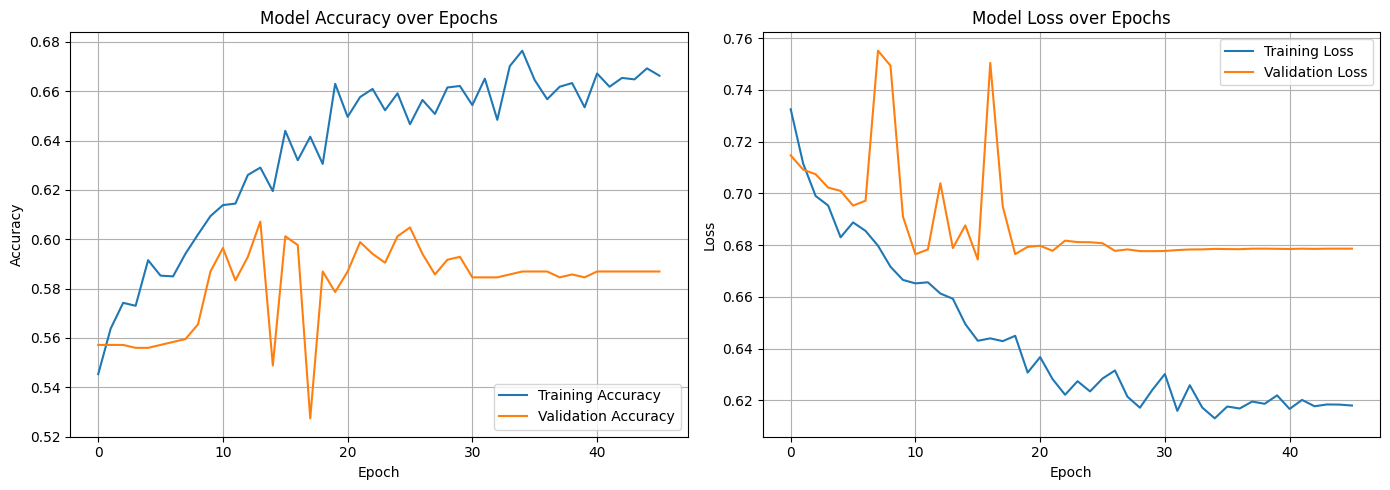

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation metrics
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


PLOT (Simple Dense Classifier)

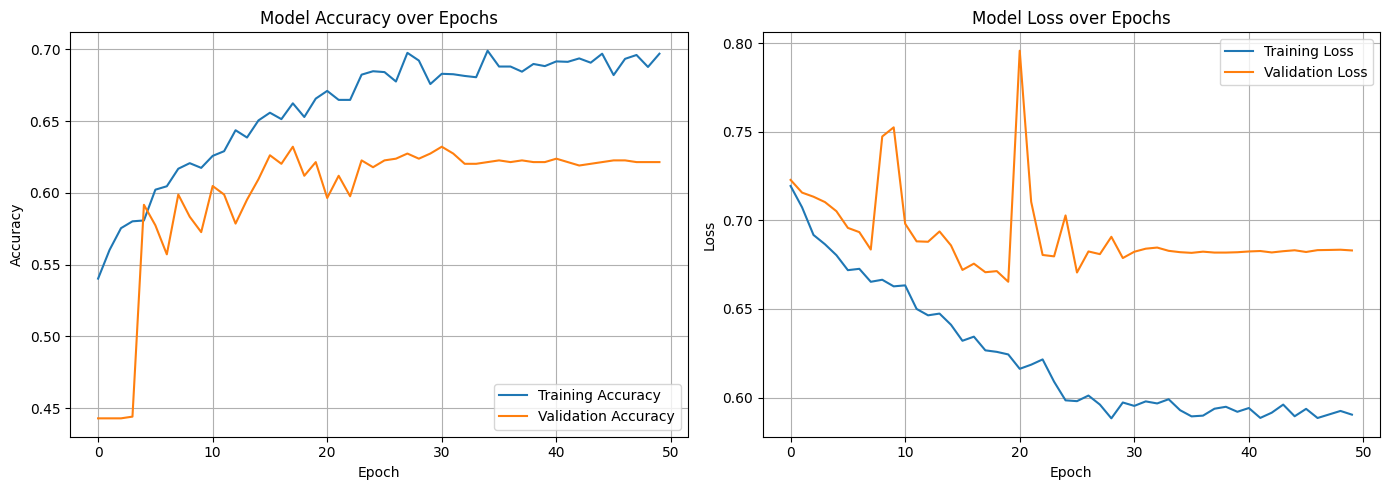

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation metrics
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()
